This notebook extracts MACS peaks that were produced by the snakemake workflow and compares the raw data (no PCR duplicates removed) with data processed to remove PCR duplicates.




In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
from collections import defaultdict
from pyfaidx import Fasta
from Bio.Seq import Seq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pybedtools as pbt

import sys
# sys.path.append("/Genomics/kocherlab/bjarnold/STARRseq/code/notebooks")
import functions as fn

In [3]:
species = "Amel"
min_biorep_support = 3 # minimum number of bioreps to support a peak
qval_threshold = 0 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 2 # default 2

# these two variables serve as flags as to whether to run the downstream analyses, extracting sequences to use for SEA or deepSTARR
# code related to this is at the very end of this notebook
downstream_sea_analysis = False
downstream_deepstarr_analysis = False

# Number of sequences to subsample from each peak set; using the same number to compare across species
number_of_seqs_to_subsample = 500
number_of_subsamples = 100
# size of interval around peak summit to sample sequences from; this is used for grabbing sequences from the reference genome
interval_size = 249
# since this inteval size is used to graab sequences around a peak, if it's odd, shift the lower and upper bound by 1
if interval_size % 2 == 0:
    interval_size_lower, interval_size_upper = int(interval_size//2), int(interval_size//2)
else:
    # if odd, since we cant divide an interval neatly into an equally sized lwoer and upper half, we'll just make the lower half 1 smaller than the upper half
    interval_size_lower, interval_size_upper = int((interval_size-1)//2), int((interval_size+1)//2)

print("These will be the number of bases on either side of the peak summit to grab sequences from:")
print(f"interval_size_lower: {interval_size_lower}")
print(f"interval_size_upper: {interval_size_upper}")

int(interval_size/2)

base_dir = "/Genomics/kocherlab/bjarnold/STARRseq/data"
input_data_dir = f"{base_dir}/peak_calling_snakemake_output/{species}"
# output directory for final, deduplicated peaks
output_dedup_peak_dir = f"{base_dir}/peak_calling_final/min_biorep_support_{min_biorep_support}/qval_{qval_threshold}_folddiff_{macs_folddiff_threshold}/{species}"
# output directory for downstream SEA (simple enrichment analysis) analyses
output_data_sea_dir = f"{base_dir}/meme_suite/min_biorep_support_{min_biorep_support}/qval_{qval_threshold}_folddiff_{macs_folddiff_threshold}/fastas/{species}"
# output directory for downstream deepSTARR analyses
output_data_deepstarr_dir = f"{base_dir}/deepSTARR_input/min_biorep_support_{min_biorep_support}/qval_{qval_threshold}_folddiff_{macs_folddiff_threshold}/{species}"
# output directory for overlapping peaks with ATAC data, for the species that it exists for
output_data_atac_dir = f"{base_dir}/ATAC_MACS_peaks_overlap/MACS_peaks/min_biorep_support_{min_biorep_support}/qval_{qval_threshold}_folddiff_{macs_folddiff_threshold}/{species}"
output_plot_dir = f"{base_dir}/plots_raw_vs_dedup/{species}"


bioreps = ['F1', 'F2', 'F3']
chr1_test = False
min_peak_interval_size = 100 # minimum peak interval size to be considered
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

import os
os.system(f"mkdir -p {output_dedup_peak_dir}")
os.system(f"mkdir -p {output_data_sea_dir}")
os.system(f"mkdir -p {output_data_deepstarr_dir}")
os.system(f"mkdir -p {output_data_atac_dir}")
os.system(f"mkdir -p {output_plot_dir}")



These will be the number of bases on either side of the peak summit to grab sequences from:
interval_size_lower: 124
interval_size_upper: 125


0

### Load MACS2 output files, convert to pyranges objects for subsequent overlapping

In [5]:
# get MACS peak files
macs_raw_files = fn.get_files(f'{input_data_dir}/MACS2', "*_peaks.narrowPeak")
macs_dedup_files = fn.get_files(f'{input_data_dir}/MACS2_dedup', "*_peaks.narrowPeak")
# print(macs_raw_files)
# print(macs_dedup_files)

# load MACS results
macs_raw_dfs = fn.load_peak_caller_results(macs_raw_files, chr1_test) # list of macs dataframes
macs_dedup_dfs = fn.load_peak_caller_results(macs_dedup_files, chr1_test) # list of macs dataframes

# filter MACS results by qval and fold diff
macs_raw_dfs = fn.filter_by_sig_effect_size(macs_raw_dfs, qval_threshold, macs_folddiff_threshold)
macs_dedup_dfs = fn.filter_by_sig_effect_size(macs_dedup_dfs, qval_threshold, macs_folddiff_threshold)

# convert to pyrange objects
macs_raw_prs = [pr.PyRanges(m) for m in macs_raw_dfs]
macs_dedup_prs = [pr.PyRanges(m) for m in macs_dedup_dfs]

print([len(df) for df in macs_raw_dfs])
print([len(df) for df in macs_dedup_dfs])


# load repeatmodeler intervals
repeat_file = f'{base_dir}/repeat_modeler_intervals/{species}_repeat_elements.bed'
# can't read with pandas because variable number of columns; some rows marked with an asterisk if the repeat overlaps with another higher-scoring repeat
# load by reading in all lines instead, then importing into table
# then use pyranges to merge overlapping intervals
# repeat_pr = fn.load_repeat_modeler_intervals(repeat_file)




before filtering: 41677
after filtering: 22954
before filtering: 40660
after filtering: 21872
before filtering: 41242
after filtering: 22722
before filtering: 21798
after filtering: 8785
before filtering: 23397
after filtering: 7843
before filtering: 32193
after filtering: 11630
[22954, 21872, 22722]
[8785, 7843, 11630]


### Load reference genome, which we will use to get sequences within peaks

In [6]:
# open reference genome ref_genome, count the length of each chromosome, and store in a dictionary
# ref_genome = f'{base_dir}/alternate_references/renamed/{species}.fasta'
ref_genome_locs = '/Genomics/kocherlab/bjarnold/STARRseq/data/reference_genome_locations.txt'
ref_genome = None
with open(ref_genome_locs, 'r') as f:
    for line in f:
        line = line.strip().split()
        if line[0] == species[0:4]:
            ref_genome = line[1]
if ref_genome is None:
    raise Exception(f"Could not find reference genome for {species}")
fasta_sequences = Fasta(ref_genome)

# get scaffold lengths, which we later use to make sure kmers don't overhang edges of scaffolds
scaff_lengths = defaultdict(int)
# Iterate over the sequences and print their names and lengths
for sequence_name in fasta_sequences.keys():
    scaff_lengths[sequence_name] = len(fasta_sequences[sequence_name])


## Plot peak interval lengths

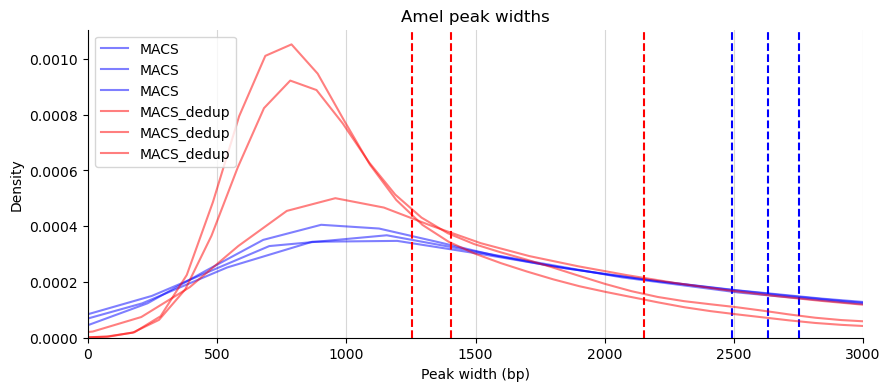

In [7]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 1, figsize=(10, 4), sharex=True, sharey=True)
for df in macs_raw_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="MACS")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in macs_dedup_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="MACS_dedup")
    axs.axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs.set_xlim(0,3000)
axs.set_xlabel("Peak width (bp)")
axs.set_ylabel("Density")
axs.set_title(f"{species} peak widths")
axs.grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, labels)
sns.despine()

plt.savefig(f"{output_plot_dir}/peak_widths.png", dpi=300, bbox_inches='tight')


## Plot fold-differences (above background) for raw and deduplicated MACS peaks

original df length: 8785
df length after join: 8793
[[1.         0.50297834]
 [0.50297834 1.        ]]
original df length: 7843
df length after join: 7848
[[1.         0.46220966]
 [0.46220966 1.        ]]
original df length: 11630
df length after join: 11713
[[1.         0.49662671]
 [0.49662671 1.        ]]


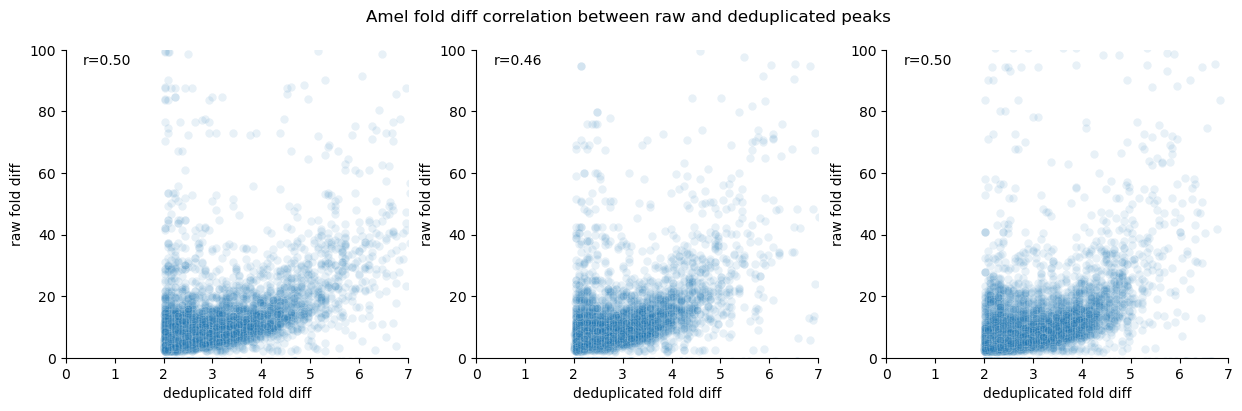

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i,(dedup,raw) in enumerate(zip(macs_dedup_prs, macs_raw_prs)):
    tmp = dedup.join(raw, suffix="_raw", how="left", preserve_order=False)
    print("original df length:", len(dedup))
    print("df length after join:", len(tmp))
    sns.scatterplot(data=tmp.df, x="signalValue", y="signalValue_raw", alpha=0.1, ax=axs[i])   
    axs[i].set_xlim(0,7)
    axs[i].set_ylim(0,100)

    axs[i].set_xlabel("deduplicated fold diff")
    axs[i].set_ylabel("raw fold diff")

    # add correlation coefficient to plot
    axs[i].text(0.05, 0.95, f"r={np.corrcoef(tmp.df['signalValue'], tmp.df['signalValue_raw'])[0,1]:.2f}", transform=axs[i].transAxes)
    print(np.corrcoef(tmp.df["signalValue"], tmp.df["signalValue_raw"]))
sns.despine()
# set title
fig.suptitle(f"{species} fold diff correlation between raw and deduplicated peaks")

plt.savefig(f"{output_plot_dir}/fold_diff_correlation.png", dpi=300, bbox_inches='tight')

### Overlap peak intervals across biological replicates, for raw and deduplicated data sets

In [9]:

# look at concordance of peak calling between methods, witihin bioreps
macs_raw_overlaps, macs_dedup_overlaps = fn.get_peak_overlaps_between_method_within_reps(macs_raw_dfs, macs_dedup_dfs, frac_overlap)

print(macs_raw_overlaps)
print(macs_dedup_overlaps)
for i,m in enumerate(macs_raw_overlaps):
    print(f"MACS2 raw: {m[0]} peaks, {m[1]*100:.2f}% overlap with deduplicated peaks")
for i,m in enumerate(macs_dedup_overlaps):
    print(f"MACS2 deduplicated: {m[0]} peaks, {m[1]*100:.2f}% overlap with raw peaks")

# fraction of overlap can seem odd if one caller has smaller peaks that are contained within a larger peak from the other caller

[(22954, 0.12599111266010282), (21872, 0.11242684711046086), (22722, 0.3078074113194261)]
[(8785, 0.9762094479225953), (7843, 0.9727145225041438), (11630, 0.9769561478933791)]
MACS2 raw: 22954 peaks, 12.60% overlap with deduplicated peaks
MACS2 raw: 21872 peaks, 11.24% overlap with deduplicated peaks
MACS2 raw: 22722 peaks, 30.78% overlap with deduplicated peaks
MACS2 deduplicated: 8785 peaks, 97.62% overlap with raw peaks
MACS2 deduplicated: 7843 peaks, 97.27% overlap with raw peaks
MACS2 deduplicated: 11630 peaks, 97.70% overlap with raw peaks


In [10]:
# look at overlaps within methods between bioreps
macs_raw_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_raw_dfs, bioreps, frac_overlap)
macs_dedup_overlaps = fn.get_peak_overlaps_within_method_between_reps(macs_dedup_dfs, bioreps, frac_overlap)

print(macs_raw_overlaps)
print(macs_dedup_overlaps)

[(22954, 21872, 16451), (22954, 22722, 16364), (21872, 22722, 15685)]
[(8785, 7843, 6193), (8785, 11630, 7948), (7843, 11630, 7276)]


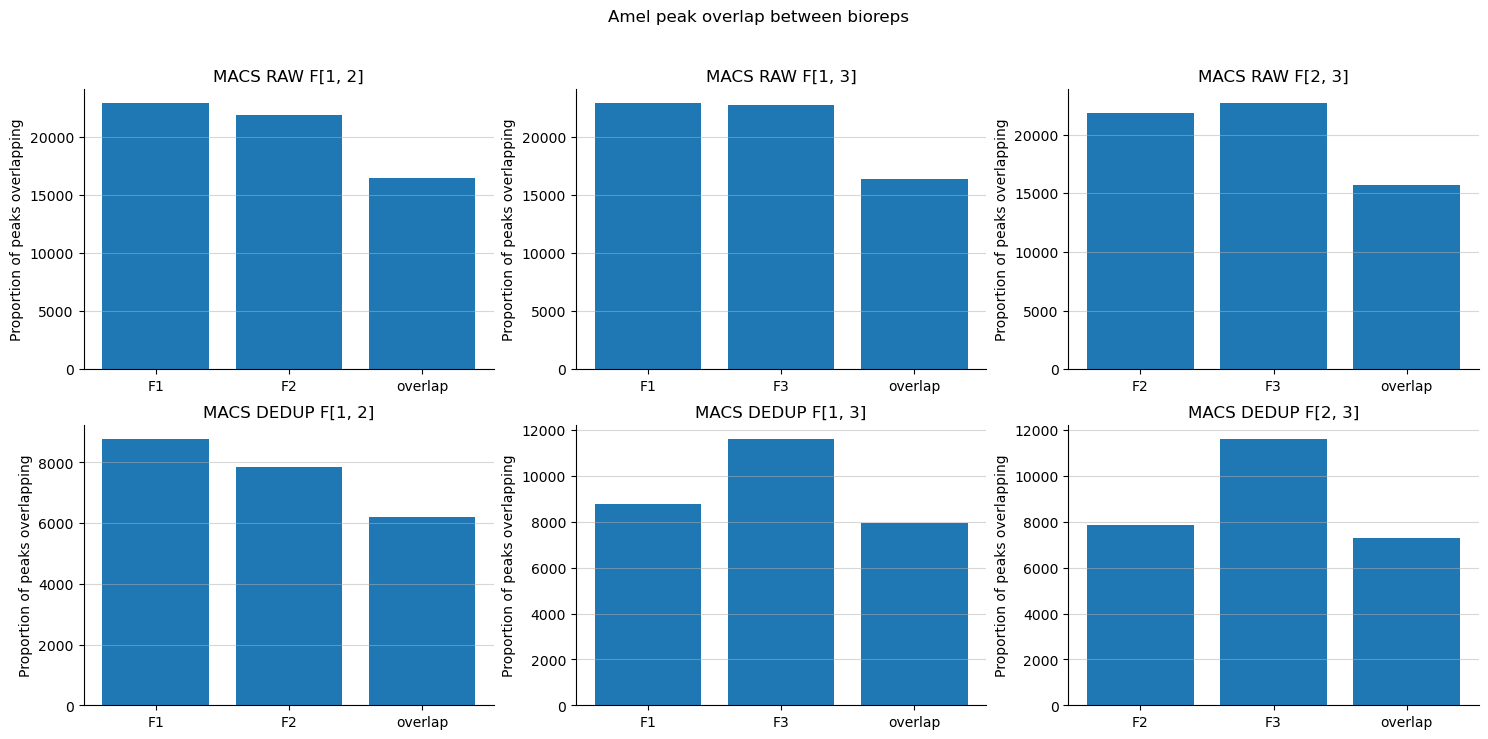

In [11]:
biorep_comb = list(itertools.combinations(range(len(bioreps)), 2))
fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
for i,comp in enumerate(macs_raw_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[0][i].bar(range(len(comp)), comp)
    axs[0][i].set_title(f"MACS RAW F{rep}")
    axs[0][i].set_ylabel("Proportion of peaks overlapping")
    axs[0][i].set_xticks(range(len(l)))
    axs[0][i].set_xticklabels(l, rotation=0)
    axs[0][i].grid(axis='y', alpha=0.5)    
for i,comp in enumerate(macs_dedup_overlaps):
    rep = biorep_comb[i]
    rep = [int(r)+1 for r in rep]
    l = [f"F{rep[0]}", f"F{rep[1]}", "overlap"]
    axs[1][i].bar(range(len(comp)), comp)
    axs[1][i].set_title(f"MACS DEDUP F{rep}")
    axs[1][i].set_ylabel("Proportion of peaks overlapping")
    axs[1][i].set_xticks(range(len(l)))
    axs[1][i].set_xticklabels(l, rotation=0)
    axs[1][i].grid(axis='y', alpha=0.5)    
sns.despine()
# add title
fig.suptitle(f"{species} peak overlap between bioreps")

plt.savefig(f"{output_plot_dir}/peak_overlap_within_method_between_reps.png", dpi=300, bbox_inches='tight')

### Categorize peaks by support across bioreps
For each peak, record how many biological replicates it was detected in

In [12]:
# convert each df to a pyranges object, count overlaps among biological replicates

macs_raw_overlaps_per_rep = fn.overlaps_per_replicate(macs_raw_dfs)
macs_dedup_overlaps_per_rep = fn.overlaps_per_replicate(macs_dedup_dfs)
# it looks like count_overlaps is counting overlaps b/t all instervals
# if all three replicates have an overlapping interval, pattern could look like this:
#       Chromosome	Start	End	    p1	p2	p3
# 7	    NMEL_chr_1	9079	9297	0	0	0
# 8	    NMEL_chr_1	9297	9309	1	0	0
# 9	    NMEL_chr_1	9309	9649	1	1	0
# 10	NMEL_chr_1	9649	10150	1	1	1
# 11	NMEL_chr_1	10150	10843	0	1	1
# 12	NMEL_chr_1	10843	10914	0	0	1
# 13	NMEL_chr_1	10914	16276	0	0	0
# where index 10 is interval in which all 3 peaks are overlapping, but since start/end points of the peaksare different,
# we can see that replicate 1 has the minimum starting point, and replicate 3 has the maximum ending point

macs_raw_overlaps_per_rep.head()

,Chromosome,Start,End,p1,p2,p3,combined
0,NC_037638.1,8589,9582,0,0,1,001
1,NC_037638.1,9582,13555,0,0,0,000
2,NC_037638.1,13555,15810,1,0,0,100
3,NC_037638.1,15810,25407,0,0,0,000
4,NC_037638.1,25407,26025,1,0,0,100


In [13]:
print(macs_raw_overlaps_per_rep.combined.unique())
print(macs_dedup_overlaps_per_rep.combined.unique())

['001' '000' '100' '010' '110' '111' '011' '101']
['001' '101' '111' '110' '010' '000' '100' '011']


In [14]:
def filter_peaks(overlaps_df, min_interval_size, min_biorep_support, method):
    df = overlaps_df[(overlaps_df['End']-overlaps_df['Start'] > min_interval_size)]
    df.reset_index(inplace=True, drop=True)
    if min_biorep_support == 3:
        df = df[(df['combined'] == '111')]
    elif min_biorep_support == 2:
        df = df[(df['combined'] == '110') | (df['combined'] == '101') | (df['combined'] == '011') | (df['combined'] == '111')]                        
    else:
        raise Exception("min_biorep_support must be 2 or 3")
    df['method'] = method
    return df
    
macs_raw_peaks_df = filter_peaks(macs_raw_overlaps_per_rep, min_peak_interval_size, min_biorep_support, 'macs_raw')
macs_dedup_peaks_df = filter_peaks(macs_dedup_overlaps_per_rep, min_peak_interval_size, min_biorep_support, 'macs_dedup')

print(len(macs_raw_peaks_df), len(macs_dedup_peaks_df))

macs_raw_peaks_df.reset_index(inplace=True, drop=True)
macs_dedup_peaks_df.reset_index(inplace=True, drop=True)


def get_signal_val_and_peak_coord_for_trips_df(trips_df, prs):
    tmp_pr = pr.PyRanges(trips_df)
    for i in range(len(prs)):
        tmp_join = tmp_pr.join(prs[i], suffix="_raw", how="left", preserve_order=True)
        tmp_join = tmp_join.df.reset_index(drop=True, inplace=False)
        # concatenate signalValue as column to macs_raw_peaks_df
        assert len(tmp_join['signalValue']) == len(trips_df)
        trips_df[f'signalValue_{i}'] = tmp_join['signalValue']
        trips_df[f'peak_coord_{i}'] = tmp_join['peak_coord'] # this is the peak summit reported by MACs, which can be outside the peak interval in which 2+ bioreps overlap
    return trips_df

macs_raw_peaks_df = get_signal_val_and_peak_coord_for_trips_df(macs_raw_peaks_df, macs_raw_prs)
macs_dedup_peaks_df = get_signal_val_and_peak_coord_for_trips_df(macs_dedup_peaks_df, macs_dedup_prs)
print(len(macs_raw_peaks_df), len(macs_dedup_peaks_df))


18597 6297
18597 6297


In [15]:
macs_dedup_peaks_df


,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2
0,NC_037638.1,3576,4081,1,1,1,111,macs_dedup,3.92549,3905,2.98108,3938,2.23553,3873
1,NC_037638.1,56260,57067,1,1,1,111,macs_dedup,3.90151,56526,3.55253,56578,3.77716,56693
2,NC_037638.1,91286,92237,1,1,1,111,macs_dedup,5.01623,91576,4.25227,91478,4.19109,91597
3,NC_037638.1,174139,176533,1,1,1,111,macs_dedup,4.45887,175384,4.35992,175381,4.44980,175384
4,NC_037638.1,179600,183294,1,1,1,111,macs_dedup,5.15557,181732,3.98314,181763,4.50154,181637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,NW_020555941.1,271,1842,1,1,1,111,macs_dedup,4.61231,1056,4.66692,1047,4.54896,1049
6293,NW_020555941.1,2915,5003,1,1,1,111,macs_dedup,17.35420,4563,15.12970,4523,12.15680,4558
6294,NW_020555942.1,3118,4898,1,1,1,111,macs_dedup,6.76695,4330,5.89920,4330,5.28632,4327
6295,NW_020555943.1,349,4227,1,1,1,111,macs_dedup,8.47578,2372,7.16490,2726,6.11835,3254


### Save peak intervals to file

In [19]:
# select everything but the 'combined' column in macs_dedup_peaks_df
macs_dedup_peaks_df.drop(columns=['combined', 'method']).to_csv(f"{output_dedup_peak_dir}/macs_dedup_peaks.tsv", sep='\t', index=False)


In [16]:
def remove_bookended_intervals_with_min_support_bioreps_2(df_input):
    # peaks detected in all 3 biological replicates are typically NOT bookended
    # however, peaks detected in only 2 biological replicates are sometimes bookended with peaks detected in all three biological replicates
    # this is because near a given enhancer, support across all three replicates will vary, such that intervals supported by 3 replicates will sometimes be flanked by intervals supported by only 2 replicates
    # since the signal fell below some threshold for one of the replicates
    bookended_indices = []
    # work by chromosome
    for chrom in df_input.Chromosome.unique():
        df = df_input[df_input['Chromosome'] == chrom]
        df.reset_index(inplace=True, drop=False) # don't drop index because we need it to remove rows later
        if len(df) == 1:
            continue
        for i,r in df.iterrows():
            if r['combined'] == '111':
                # only remove intervals with support from less than 3 bioreps
                continue
            if i==0:
                # if i == 0, see if bookended with i+1
                if r['End'] == df.iloc[i+1]['Start']:
                    bookended_indices.append(r['index'])
            elif i==len(df)-1:
                # if i == len(df)-1, see if bookended with i-1
                if r['Start'] == df.iloc[i-1]['End']:
                    bookended_indices.append(r['index'])
            else:
                # else compare to both flanking indices
                if (r['End'] == df.iloc[i+1]['Start']) or (r['Start'] == df.iloc[i-1]['End']):
                    bookended_indices.append(r['index'])
    print(len(bookended_indices))

    return df_input[~df_input.index.isin(bookended_indices)].reset_index(drop=True)


print("MACS raw before removing bookends:", len(macs_raw_peaks_df))
macs_raw_peaks_df = remove_bookended_intervals_with_min_support_bioreps_2(macs_raw_peaks_df)
print("MACS raw after removing bookends:", len(macs_raw_peaks_df))

print("MACS dedup before removing bookends:", len(macs_dedup_peaks_df))
macs_dedup_peaks_df = remove_bookended_intervals_with_min_support_bioreps_2(macs_dedup_peaks_df)
print("MACS dedup after removing bookends:", len(macs_dedup_peaks_df))


MACS raw before removing bookends: 18597
0
MACS raw after removing bookends: 18597
MACS dedup before removing bookends: 6297
0
MACS dedup after removing bookends: 6297


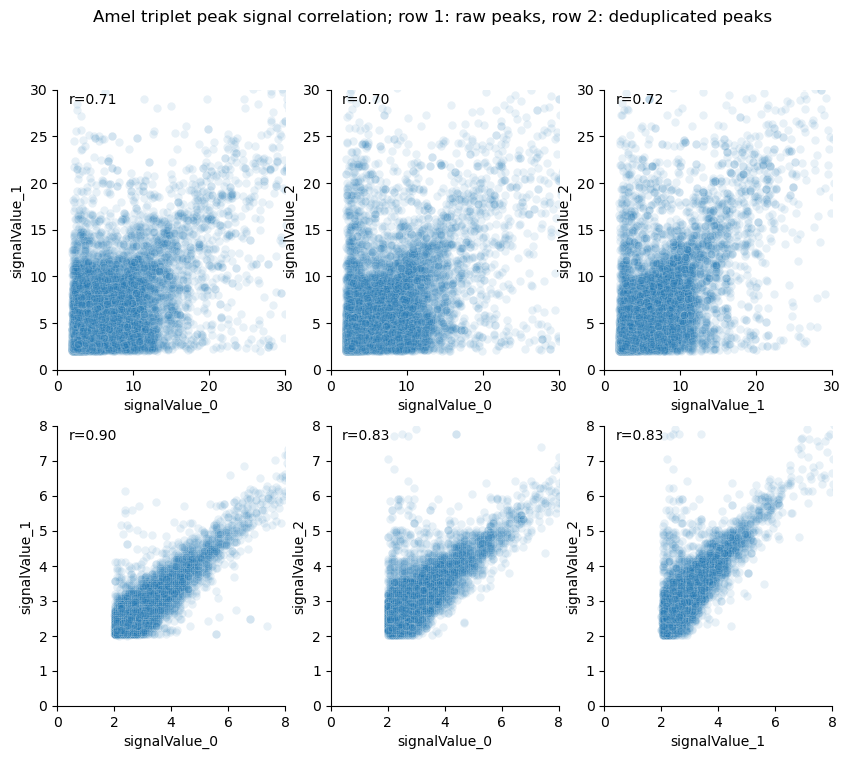

In [17]:
# make pairwise comparisons of signal values columns
fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=False, sharey=False)
#get all combinations of integers between 0 and 2
for i, comb in enumerate(list(itertools.combinations(range(3), 2))):
    sns.scatterplot(data=macs_raw_peaks_df, x=f"signalValue_{comb[0]}", y=f"signalValue_{comb[1]}", alpha=0.1, ax=axs[0][i])
    axs[0][i].set_xlim(0,30)
    axs[0][i].set_ylim(0,30)
    # print pearson correlation coefficient
    axs[0][i].text(0.05, 0.95, f"r={np.corrcoef(macs_raw_peaks_df[f'signalValue_{comb[0]}'], macs_raw_peaks_df[f'signalValue_{comb[1]}'])[0,1]:.2f}", transform=axs[0][i].transAxes)


    sns.scatterplot(data=macs_dedup_peaks_df, x=f"signalValue_{comb[0]}", y=f"signalValue_{comb[1]}", alpha=0.1, ax=axs[1][i])
    axs[1][i].set_xlim(0,8)
    axs[1][i].set_ylim(0,8)
    # print pearson correlation coefficient
    axs[1][i].text(0.05, 0.95, f"r={np.corrcoef(macs_dedup_peaks_df[f'signalValue_{comb[0]}'], macs_dedup_peaks_df[f'signalValue_{comb[1]}'])[0,1]:.2f}", transform=axs[1][i].transAxes)
sns.despine()

# add title
fig.suptitle(f"{species} triplet peak signal correlation; row 1: raw peaks, row 2: deduplicated peaks")
plt.savefig(f"{output_plot_dir}/triplet_peak_signal_correlation_across_reps.png", dpi=300, bbox_inches='tight')

In [18]:
macs_dedup_peaks_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,signalValue_1,peak_coord_1,signalValue_2,peak_coord_2
0,NC_037638.1,3576,4081,1,1,1,111,macs_dedup,3.92549,3905,2.98108,3938,2.23553,3873
1,NC_037638.1,56260,57067,1,1,1,111,macs_dedup,3.90151,56526,3.55253,56578,3.77716,56693
2,NC_037638.1,91286,92237,1,1,1,111,macs_dedup,5.01623,91576,4.25227,91478,4.19109,91597
3,NC_037638.1,174139,176533,1,1,1,111,macs_dedup,4.45887,175384,4.35992,175381,4.44980,175384
4,NC_037638.1,179600,183294,1,1,1,111,macs_dedup,5.15557,181732,3.98314,181763,4.50154,181637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6292,NW_020555941.1,271,1842,1,1,1,111,macs_dedup,4.61231,1056,4.66692,1047,4.54896,1049
6293,NW_020555941.1,2915,5003,1,1,1,111,macs_dedup,17.35420,4563,15.12970,4523,12.15680,4558
6294,NW_020555942.1,3118,4898,1,1,1,111,macs_dedup,6.76695,4330,5.89920,4330,5.28632,4327
6295,NW_020555943.1,349,4227,1,1,1,111,macs_dedup,8.47578,2372,7.16490,2726,6.11835,3254


### compute mean signal value, mean peak coordinate

In [158]:
def compute_mean_value_across_reps(df, col_prefix):
    # we need a more complicated function here to accomodate for peaks that are only supported by 2 bioreps
    mean_values = []
    for i,r in df.iterrows():
        # only take values from bioreps that contained that peak interval
        bioreps_to_avg = [i for i in range(3) if r['combined'][i] == '1']
        mean_values.append( np.mean([r[f'{col_prefix}_{i}'] for i in bioreps_to_avg]) )
    return mean_values

# compute the mean signal value across replicates
macs_raw_peaks_df['mean_signalValue'] = compute_mean_value_across_reps(macs_raw_peaks_df, 'signalValue')
macs_dedup_peaks_df['mean_signalValue'] = compute_mean_value_across_reps(macs_dedup_peaks_df, 'signalValue')

# get midpoint peak_coord and convert to integer
macs_raw_peaks_df['mid_peak_coord'] = (macs_raw_peaks_df['Start'] + macs_raw_peaks_df['End'])//2
macs_dedup_peaks_df['mid_peak_coord'] = (macs_dedup_peaks_df['Start'] + macs_dedup_peaks_df['End'])//2

# get summit peak_coord
macs_raw_peaks_df['mean_summit_coord'] = compute_mean_value_across_reps(macs_raw_peaks_df, 'peak_coord')
macs_dedup_peaks_df['mean_summit_coord'] = compute_mean_value_across_reps(macs_dedup_peaks_df, 'peak_coord')

# convert 'mean_summit_coord' to integer
macs_raw_peaks_df['mean_summit_coord'] = macs_raw_peaks_df['mean_summit_coord'].astype(int)
macs_dedup_peaks_df['mean_summit_coord'] = macs_dedup_peaks_df['mean_summit_coord'].astype(int)

# # compute the mean signal value across replicates
# macs_raw_peaks_df['mean_signalValue'] = macs_raw_peaks_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)
# macs_dedup_peaks_df['mean_signalValue'] = macs_dedup_peaks_df[[f'signalValue_{i}' for i in range(3)]].mean(axis=1)

# # get mean peak_coord and convert to integer
# macs_raw_peaks_df['mean_peak_coord'] = macs_raw_peaks_df[[f'peak_coord_{i}' for i in range(3)]].mean(axis=1).astype(int)
# macs_dedup_peaks_df['mean_peak_coord'] = macs_dedup_peaks_df[[f'peak_coord_{i}' for i in range(3)]].mean(axis=1).astype(int)



### get interval coordinates around peak mid-point coordinate, these intervals will be used to look for enrichment in TF motifs using SEA

In [159]:
# extend mid peak coordinate to match interval size
macs_raw_peaks_df['mid_Start'] = macs_raw_peaks_df['mid_peak_coord'] - (interval_size_lower)
macs_raw_peaks_df['mid_End'] = macs_raw_peaks_df['mid_peak_coord'] + (interval_size_upper)

macs_dedup_peaks_df['mid_Start'] = macs_dedup_peaks_df['mid_peak_coord'] - (interval_size_lower)
macs_dedup_peaks_df['mid_End'] = macs_dedup_peaks_df['mid_peak_coord'] + (interval_size_upper)



### get interval coordinates around peak summit

In [160]:

macs_raw_peaks_df['peak_Start'] = macs_raw_peaks_df['mean_summit_coord'] - (interval_size_lower)
macs_raw_peaks_df['peak_End'] = macs_raw_peaks_df['mean_summit_coord'] + (interval_size_upper)

macs_dedup_peaks_df['peak_Start'] = macs_dedup_peaks_df['mean_summit_coord'] - (interval_size_lower)
macs_dedup_peaks_df['peak_End'] = macs_dedup_peaks_df['mean_summit_coord'] + (interval_size_upper)

In [161]:
macs_dedup_peaks_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,...,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mid_peak_coord,mean_summit_coord,mid_Start,mid_End,peak_Start,peak_End
0,AAUR_chr_1,11251,11800,1,1,1,111,macs_dedup,2.16950,11622,...,11621,2.05751,11621,2.107277,11525,11621,11401,11650,11497,11746
1,AAUR_chr_1,125753,126396,1,1,1,111,macs_dedup,2.34225,126191,...,126192,2.02701,126191,2.215873,126074,126191,125950,126199,126067,126316
2,AAUR_chr_1,321802,322535,1,1,1,111,macs_dedup,3.06974,322244,...,322243,2.15975,322243,2.487880,322168,322243,322044,322293,322119,322368
3,AAUR_chr_1,327624,328379,1,1,1,111,macs_dedup,2.79123,328083,...,328080,2.24232,328080,2.435777,328001,328081,327877,328126,327957,328206
4,AAUR_chr_1,331226,331968,1,1,1,111,macs_dedup,2.87286,331679,...,331674,2.07918,331676,2.393253,331597,331676,331473,331722,331552,331801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,AAUR_chr_22,499679,499992,1,1,1,111,macs_dedup,2.42149,499783,...,499777,2.07312,499786,2.214840,499835,499782,499711,499960,499658,499907
409,AAUR_chr_22,540479,540912,1,1,1,111,macs_dedup,2.56438,540662,...,540659,2.63288,540662,2.621207,540695,540661,540571,540820,540537,540786
410,AAUR_chr_22,1745194,1745516,1,1,1,111,macs_dedup,2.22569,1745242,...,1745496,2.10101,1745483,2.395657,1745355,1745407,1745231,1745480,1745283,1745532
411,AAUR_chr_22,5042301,5044150,1,1,1,111,macs_dedup,3.38692,5042116,...,5043898,2.10631,5042437,2.590583,5043225,5042817,5043101,5043350,5042693,5042942


### When we created intervals around some coordinate, there's a small chance we went beyond the limits of the chromosome/scaffold

In [162]:
# get rid of intervals that go beyond boundaries of scaffolds
def get_indices_of_overhangs(df, scaff_lengths, coord_type):
    # get indices of intervals that overhang scaffolds
    overhang_indices = []
    for i,r in df.iterrows():
        if (r[f'{coord_type}_Start'] < 0) or (r[f'{coord_type}_End'] > scaff_lengths[r['Chromosome']]):
            overhang_indices.append(i)
    return overhang_indices

macs_raw_overhang_indices = get_indices_of_overhangs(macs_raw_peaks_df, scaff_lengths, 'peak') 
macs_dedup_overhang_indices = get_indices_of_overhangs(macs_dedup_peaks_df, scaff_lengths, 'peak')

print("macs_raw_overhang_indices overhangs: ", len(macs_raw_overhang_indices))
print("macs_dedup_overhang_indices overhangs: ", len(macs_dedup_overhang_indices))

# get all indices of macs_raw_peaks_df except for those in macs_raw_overhang_indices
macs_raw_peaks_df = macs_raw_peaks_df[~macs_raw_peaks_df.index.isin(macs_raw_overhang_indices)].reset_index(drop=True)

macs_dedup_peaks_df = macs_dedup_peaks_df[~macs_dedup_peaks_df.index.isin(macs_dedup_overhang_indices)].reset_index(drop=True)
 

macs_raw_overhang_indices overhangs:  0
macs_dedup_overhang_indices overhangs:  0


### Record the number of MACS peaks for downstream analyses

In [163]:
with open(f"./MACS2_summaries/min_biorep_support_{min_biorep_support}/{species}_MACS2_peaks_qval_{qval_threshold}_folddiff_{macs_folddiff_threshold}.txt",'w') as o:
    o.write(" ".join(["species", "raw", "dedup", "\n"]))
    o.write(" ".join([species, str(len(macs_raw_peaks_df)), str(len(macs_dedup_peaks_df)), "\n"]))

In [164]:
macs_raw_peaks_df

,Chromosome,Start,End,p1,p2,p3,combined,method,signalValue_0,peak_coord_0,...,peak_coord_1,signalValue_2,peak_coord_2,mean_signalValue,mid_peak_coord,mean_summit_coord,mid_Start,mid_End,peak_Start,peak_End
0,AAUR_chr_1,3658,4269,1,1,1,111,macs_raw,2.31387,4007,...,4009,2.15966,4010,2.193020,3963,4008,3839,4088,3884,4133
1,AAUR_chr_1,111511,112013,1,1,1,111,macs_raw,2.24087,111805,...,111809,2.04981,111809,2.121883,111762,111807,111638,111887,111683,111932
2,AAUR_chr_1,333327,334425,1,1,1,111,macs_raw,2.01798,334053,...,334054,2.36545,334050,2.152033,333876,334052,333752,334001,333928,334177
3,AAUR_chr_1,444825,447219,1,1,1,111,macs_raw,2.32694,447001,...,447005,2.41259,447004,2.290647,446022,447003,445898,446147,446879,447128
4,AAUR_chr_1,511289,511669,1,1,1,111,macs_raw,3.37628,511502,...,511605,2.26446,511489,3.018897,511479,511532,511355,511604,511408,511657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,AAUR_chr_22,4945673,4946571,1,1,1,111,macs_raw,2.06750,4946508,...,4945009,3.30810,4945859,2.827307,4946122,4945792,4945998,4946247,4945668,4945917
5022,AAUR_chr_22,4986473,4986753,1,1,1,111,macs_raw,2.46615,4986479,...,4986667,2.48997,4986915,2.521420,4986613,4986687,4986489,4986738,4986563,4986812
5023,AAUR_chr_22,5005386,5006017,1,1,1,111,macs_raw,3.65411,5005731,...,5005729,2.61447,5005710,3.256840,5005701,5005723,5005577,5005826,5005599,5005848
5024,AAUR_chr_22,5006595,5007303,1,1,1,111,macs_raw,3.84546,5006828,...,5006830,2.66783,5006796,2.864647,5006949,5006818,5006825,5007074,5006694,5006943


## Save intervals as BED file, load into pybedtools object to extract underlying sequences from FASTA file, since this function is bugged in PyRanges

### For 'SIMPLE ENRICHMENT ANALYSIS" (SEA): Since raw data likely has many more peaks compared to deduplicated data, downsample raw data to as many observations in deduplicated data, since you may find more TFBS enrichment from sampling random regions of the genome

In [165]:
# load in reference genome as pybedtools object
ref_genome_pbt = pbt.example_filename(ref_genome)

if downstream_sea_analysis:

    # randomly sample rows from macs_raw_peaks_df
    for i in range(number_of_subsamples):
        macs_raw_trips_subsamp_df = macs_raw_peaks_df.sample(n=number_of_seqs_to_subsample, replace=True).reset_index(drop=True) 
        macs_raw_trips_subsamp_df[['Chromosome', 'mid_Start', 'mid_End']].to_csv(f'{output_data_sea_dir}/MACS2_triplet_peaks_raw_rep{i}.bed', sep='\t', header=False, index=False)
        macs_raw_trips_subsamp_pbt = pbt.BedTool(f'{output_data_sea_dir}/MACS2_triplet_peaks_raw_rep{i}.bed')
        macs_raw_trips_subsamp_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_sea_dir}/MACS2_triplet_peaks_raw_rep{i}.fa")

    # randomly sample rows from macs_dedup_peaks_df
    for i in range(number_of_subsamples):
        macs_dedup_trips_subsamp_df = macs_dedup_peaks_df.sample(n=number_of_seqs_to_subsample, replace=True).reset_index(drop=True) 
        macs_dedup_trips_subsamp_df[['Chromosome', 'mid_Start', 'mid_End']].to_csv(f'{output_data_sea_dir}/MACS2_triplet_peaks_dedup_rep{i}.bed', sep='\t', header=False, index=False)
        macs_dedup_trips_subsamp_pbt = pbt.BedTool(f'{output_data_sea_dir}/MACS2_triplet_peaks_dedup_rep{i}.bed')
        macs_dedup_trips_subsamp_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_sea_dir}/MACS2_triplet_peaks_dedup_rep{i}.fa")

    for i in range(number_of_subsamples):
        x = pbt.BedTool()
        y = x.random(l=interval_size, n=number_of_seqs_to_subsample, g=f"{ref_genome}.fai")
        y.sequence(fi=ref_genome_pbt, fo=f"{output_data_sea_dir}/MACS2_triplet_peaks_random_rep{i}.fa")


# print(open(tmp.seqfn).read())


In [166]:
if downstream_deepstarr_analysis:

    macs_raw_peaks_df[['Chromosome', 'peak_Start', 'peak_End', 'mean_signalValue']].to_csv(f'{output_data_deepstarr_dir}/MACS2_peaks_raw.bed', sep='\t', header=False, index=False)
    macs_raw_peaks_pbt = pbt.BedTool(f'{output_data_deepstarr_dir}/MACS2_peaks_raw.bed')
    macs_raw_peaks_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_deepstarr_dir}/MACS2_peaks_raw.fa")

    macs_dedup_peaks_df[['Chromosome', 'peak_Start', 'peak_End', 'mean_signalValue']].to_csv(f'{output_data_deepstarr_dir}/MACS2_peaks_dedup.bed', sep='\t', header=False, index=False)
    macs_dedup_peaks_pbt = pbt.BedTool(f'{output_data_deepstarr_dir}/MACS2_peaks_dedup.bed')
    macs_dedup_peaks_pbt.sequence(fi=ref_genome_pbt, fo=f"{output_data_deepstarr_dir}/MACS2_peaks_dedup.fa")

    x = pbt.BedTool()
    y = x.random(l=interval_size, n=10000, g=f"{ref_genome}.fai", seed=1)
    y.sequence(fi=ref_genome_pbt, fo=f"{output_data_deepstarr_dir}/random_seqs.fa")


# Output peak interval files to overlap with ATACseq data (which only exists for a few species)

In [168]:
macs_raw_peaks_df.to_csv(f'{output_data_atac_dir}/MACS2_peaks_raw.tsv', sep='\t', header=True, index=False)
macs_dedup_peaks_df.to_csv(f'{output_data_atac_dir}/MACS2_peaks_dedup.tsv', sep='\t', header=True, index=False)